In [ ]:
# !pip install --upgrade statsmodels

In [ ]:
# !pip install tslearn

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load Libraries

import pandas as pd
import scipy.stats as st
import numpy as np
import io 
import matplotlib.pyplot as plt
from random import random
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from tslearn.clustering import TimeSeriesKMeans


In [ ]:
# ##Uploading datasets
# from google.colab import files 
# uploaded = files.upload()


In [ ]:
HousingDataUSA = pd.read_csv('Median Raw Sale Price Monthly View.csv')
HousingDataUSA

,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,...,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,102001,0,United States,Country,NaN,193000.0,196500.0,195000.0,197500.0,202000.0,200000.0,199900.0,190000.0,190000.0,185000.0,185000.0,177500.0,175000.0,175000.0,173000.0,177900.0,184000.0,183000.0,182000.0,176000.0,175000.0,174000.0,178000.0,175000.0,170000.0,175000.0,170000.0,175000.0,180000.0,185000.0,185000.0,180000.0,175500.0,175500.0,179000.0,...,235000.0,237000.0,240000.0,235000.0,238000.0,243000.0,245000.0,249000.0,255000.0,250000.0,249655.0,245000.0,243000.0,245300.0,247700.0,243000.0,242500.0,249990.0,253000.0,260000.0,265000.0,262500.0,260000.0,257000.0,257000.0,259000.0,261000.0,255000.0,260000.0,266100.0,267000.0,264900.0,272500.0,283980.0,285000.0,289900.0,290000.0,292000.0,290000.0,287500.0
1,394913,1,"New York, NY",Msa,NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,399000.0,400501.0,400000.0,400000.0,399995.0,397000.0,400000.0,412000.0,425000.0,432500.0,432500.0,421800.0,408500.0,410000.0,405000.0,410000.0,410000.0,400000.0,410000.0,420000.0,435000.0,440000.0,432500.0,429000.0,421256.0,420000.0,420000.0,425000.0,425000.0,425000.0,435000.0,435000.0,450000.0,449450.0,455000.0,462000.0,470000.0,478000.0,469000.0,475000.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,510000.0,500000.0,500000.0,489000.0,483000.0,475000.0,450000.0,440000.0,440000.0,420000.0,422000.0,395000.0,405000.0,400000.0,394375.0,415000.0,422500.0,420000.0,410000.0,420000.0,407500.0,405000.0,400000.0,394000.0,385000.0,400000.0,395000.0,410000.0,400000.0,405000.0,400000.0,405000.0,390000.0,395000.0,390000.0,...,610000.0,620000.0,619000.0,600000.0,629000.0,637000.0,638000.0,655000.0,660000.0,650000.0,652000.0,641000.0,640000.0,645995.0,630000.0,620000.0,634500.0,645000.0,653500.0,649000.0,659000.0,675000.0,655000.0,659500.0,655000.0,656000.0,665000.0,660000.0,665000.0,686000.0,674000.0,660000.0,690000.0,715000.0,730000.0,738000.0,740000.0,730000.0,730000.0,726000.0
3,394463,3,"Chicago, IL",Msa,IL,250000.0,246250.0,249900.0,250000.0,255000.0,259000.0,255000.0,245000.0,235000.0,225000.0,226500.0,215000.0,204000.0,215000.0,215000.0,217500.0,225000.0,222000.0,220000.0,211000.0,203000.0,200000.0,200000.0,196000.0,187500.0,200000.0,202500.0,207500.0,220000.0,210000.0,217000.0,200000.0,200000.0,190000.0,190000.0,...,219000.0,217000.0,220000.0,215845.0,218000.0,230000.0,239900.0,240000.0,250000.0,244000.0,234500.0,229000.0,223000.0,225000.0,220000.0,216250.0,223000.0,233750.0,241000.0,247000.0,250000.0,250000.0,242500.0,235000.0,233000.0,234000.0,230000.0,225000.0,229000.0,250000.0,260000.0,250000.0,255000.0,265000.0,268500.0,265000.0,270000.0,260000.0,257000.0,255000.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,145000.0,153490.0,152000.0,155990.0,160000.0,160000.0,158000.0,149900.0,149900.0,144500.0,144495.0,136900.0,142000.0,145000.0,145000.0,154250.0,160000.0,158350.0,156900.0,150000.0,147000.0,145261.0,145000.0,136725.0,145000.0,149900.0,152915.0,153000.0,159000.0,159500.0,162000.0,153000.0,148000.0,150000.0,155000.0,...,249995.0,252000.0,259990.0,246000.0,255000.0,265000.0,265000.

###Data Cleaning

In [ ]:
CleanData = HousingDataUSA.drop(columns= ['RegionID', 'SizeRank', 'RegionType','2008-02-29',	'2008-03-31',	'2008-04-30',	'2008-05-31',	'2008-06-30',	'2008-07-31',	'2008-08-31',	'2008-09-30',	'2008-10-31',	'2008-11-30',	'2008-12-31',	'2009-01-31',	'2009-02-28',	'2009-03-31',	'2009-04-30',	'2009-05-31',	'2009-06-30',	'2009-07-31',	'2009-08-31',	'2009-09-30',	'2009-10-31',	'2009-11-30',	'2009-12-31'])

In [ ]:
CleanData.head()

,RegionName,StateName,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,...,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
0,United States,NaN,175000.0,170000.0,175000.0,170000.0,175000.0,180000.0,185000.0,185000.0,180000.0,175500.0,175500.0,179000.0,170000.0,168000.0,167000.0,168000.0,171500.0,178000.0,176000.0,175000.0,170000.0,165844.0,167000.0,168000.0,160000.0,160000.0,165000.0,171000.0,177000.0,185000.0,184900.0,183000.0,179000.0,176500.0,180000.0,183115.0,175000.0,175000.0,...,235000.0,237000.0,240000.0,235000.0,238000.0,243000.0,245000.0,249000.0,255000.0,250000.0,249655.0,245000.0,243000.0,245300.0,247700.0,243000.0,242500.0,249990.0,253000.0,260000.0,265000.0,262500.0,260000.0,257000.0,257000.0,259000.0,261000.0,255000.0,260000.0,266100.0,267000.0,264900.0,272500.0,283980.0,285000.0,289900.0,290000.0,292000.0,290000.0,287500.0
1,"New York, NY",NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348500.0,345000.0,350000.0,355000.0,360000.0,380000.0,381500.0,375000.0,375000.0,362500.0,360000.0,355000.0,351000.0,346000.0,...,399000.0,400501.0,400000.0,400000.0,399995.0,397000.0,400000.0,412000.0,425000.0,432500.0,432500.0,421800.0,408500.0,410000.0,405000.0,410000.0,410000.0,400000.0,410000.0,420000.0,435000.0,440000.0,432500.0,429000.0,421256.0,420000.0,420000.0,425000.0,425000.0,425000.0,435000.0,435000.0,450000.0,449450.0,455000.0,462000.0,470000.0,478000.0,469000.0,475000.0
2,"Los Angeles-Long Beach-Anaheim, CA",CA,394000.0,385000.0,400000.0,395000.0,410000.0,400000.0,405000.0,400000.0,405000.0,390000.0,395000.0,390000.0,375000.0,378000.0,392250.0,390000.0,395000.0,400000.0,395000.0,380000.0,386250.0,365000.0,365000.0,360000.0,349000.0,355000.0,373000.0,385000.0,385000.0,395000.0,397000.0,395000.0,399000.0,400000.0,400000.0,418000.0,400000.0,405000.0,...,610000.0,620000.0,619000.0,600000.0,629000.0,637000.0,638000.0,655000.0,660000.0,650000.0,652000.0,641000.0,640000.0,645995.0,630000.0,620000.0,634500.0,645000.0,653500.0,649000.0,659000.0,675000.0,655000.0,659500.0,655000.0,656000.0,665000.0,660000.0,665000.0,686000.0,674000.0,660000.0,690000.0,715000.0,730000.0,738000.0,740000.0,730000.0,730000.0,726000.0
3,"Chicago, IL",IL,196000.0,187500.0,200000.0,202500.0,207500.0,220000.0,210000.0,217000.0,200000.0,200000.0,190000.0,190000.0,181750.0,178000.0,172000.0,183000.0,185000.0,195000.0,199900.0,195000.0,175000.0,169000.0,164000.0,160000.0,152700.0,148150.0,164000.0,175000.0,180000.0,196500.0,195000.0,186000.0,175000.0,161500.0,167000.0,163000.0,153000.0,149000.0,...,219000.0,217000.0,220000.0,215845.0,218000.0,230000.0,239900.0,240000.0,250000.0,244000.0,234500.0,229000.0,223000.0,225000.0,220000.0,216250.0,223000.0,233750.0,241000.0,247000.0,250000.0,250000.0,242500.0,235000.0,233000.0,234000.0,230000.0,225000.0,229000.0,250000.0,260000.0,250000.0,255000.0,265000.0,268500.0,265000.0,270000.0,260000.0,257000.0,255000.0
4,"Dallas-Fort Worth, TX",TX,136725.0,145000.0,149900.0,152915.0,153000.0,159000.0,159500.0,162000.0,153000.0,148000.0,150000.0,155000.0,146395.0,147500.0,146000.0,148000.0,155000.0,156500.0,159000.0,158000.0,151000.0,149900.0,147000.0,155000.0,145000.0,150000.0,158000.0,160000.0,166500.0,170500.0,169000.0,166

In [ ]:
CaliforniaCities = CleanData.loc[CleanData['StateName'] == 'CA']
CaliforniaCities

,RegionName,StateName,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,...,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
2,"Los Angeles-Long Beach-Anaheim, CA",CA,394000.0,385000.0,400000.0,395000.0,410000.0,400000.0,405000.0,400000.0,405000.0,390000.0,395000.0,390000.0,375000.0,378000.0,392250.0,390000.0,395000.0,400000.0,395000.0,380000.0,386250.0,365000.0,365000.0,360000.0,349000.0,355000.0,373000.0,385000.0,385000.0,395000.0,397000.0,395000.0,399000.0,400000.0,400000.0,418000.0,400000.0,405000.0,...,610000.0,620000.0,619000.0,600000.0,629000.0,637000.0,638000.0,655000.0,660000.0,650000.0,652000.0,641000.0,640000.0,645995.0,630000.0,620000.0,634500.0,645000.0,653500.0,649000.0,659000.0,675000.0,655000.0,659500.0,655000.0,656000.0,665000.0,660000.0,665000.0,686000.0,674000.0,660000.0,690000.0,715000.0,730000.0,738000.0,740000.0,730000.0,730000.0,726000.0
11,"San Francisco, CA",CA,375000.0,385000.0,412000.0,420000.0,451250.0,455000.0,459000.0,445000.0,435000.0,428750.0,422250.0,405000.0,360000.0,369450.0,408000.0,399000.0,415000.0,425000.0,406750.0,402500.0,393000.0,375000.0,380000.0,361750.0,330000.0,340000.0,380000.0,414000.0,450000.0,462000.0,460000.0,435000.0,437000.0,445000.0,465000.0,455000.0,409500.0,430500.0,...,780000.0,789500.0,750000.0,705000.0,766000.0,825000.0,848000.0,856000.0,870000.0,830000.0,800000.0,782500.0,825000.0,800000.0,769000.0,710500.0,765000.0,790000.0,830000.0,850000.0,845000.0,800000.0,782250.0,777500.0,816500.0,800000.0,785000.0,750000.0,760000.0,825000.0,835000.0,825000.0,858000.0,895000.0,905000.0,900000.0,900000.0,910000.0,885000.0,860000.0
13,"Riverside, CA",CA,208000.0,208000.0,215000.0,200000.0,214000.0,215000.0,209000.0,201000.0,205000.0,200000.0,205000.0,204000.0,200000.0,200000.0,203000.0,199000.0,201000.0,200000.0,196250.0,195000.0,195000.0,192250.0,195000.0,190750.0,189250.0,195000.0,202000.0,200000.0,205000.0,205000.0,206000.0,193000.0,205000.0,210000.0,221000.0,225000.0,220000.0,223000.0,...,345750.0,350000.0,355000.0,353000.0,366000.0,363000.0,365000.0,370000.0,370000.0,370000.0,364000.0,370000.0,365000.0,370000.0,365000.0,360000.0,368000.0,370000.0,371500.0,370000.0,372500.0,375000.0,373750.0,375000.0,375000.0,375000.0,382500.0,380000.0,390000.0,393000.0,387000.0,395000.0,404163.0,410000.0,419000.0,429000.0,430000.0,430000.0,435000.0,440000.0
17,"San Diego, CA",CA,349000.0,355000.0,375000.0,360000.0,370000.0,375000.0,374000.0,378000.0,373000.0,365000.0,365000.0,370000.0,335000.0,345000.0,370000.0,355000.0,360000.0,369000.0,360000.0,355000.0,350000.0,350000.0,340000.0,349750.0,335000.0,335000.0,350000.0,353000.0,360000.0,366000.0,359000.0,364000.0,362000.0,364500.0,373000.0,385000.0,365000.0,375000.0,...,542500.0,550000.0,557500.0,543000.0,549000.0,569000.0,585000.0,583000.0,590000.0,595000.0,595500.0,590000.0,579500.0,590000.0,570000.0,573500.0,570000.0,581000.0,581250.0,580000.0,600000.0,585000.0,592500.0,575000.0,587000.0,600000.0,580000.0,599000.0,605000.0,599000.0,600000.0,590000.0,605000.0,639000.0,650000.0,655000.0,650000.0,655000.0,650000.0,650000.0
25,"Sacramento, CA",CA,225000.0,225000.0,231000.0,229000.0,231500.0,238750.0,240000.0,225000.0,232000.0,230000.0,239000.0,230000.0,215000.0,223750.0,220000.0,224000.0,218000.0,2250

In [ ]:
TexasCities = CleanData.loc[CleanData['StateName'] == 'TX'][:5]
TexasCities

,RegionName,StateName,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,...,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
4,"Dallas-Fort Worth, TX",TX,136725.0,145000.0,149900.0,152915.0,153000.0,159000.0,159500.0,162000.0,153000.0,148000.0,150000.0,155000.0,146395.0,147500.0,146000.0,148000.0,155000.0,156500.0,159000.0,158000.0,151000.0,149900.0,147000.0,155000.0,145000.0,150000.0,158000.0,160000.0,166500.0,170500.0,169000.0,166900.0,165500.0,160500.0,160315.0,167000.0,159000.0,160500.0,...,249995.0,252000.0,259990.0,246000.0,255000.0,265000.0,265000.0,275000.0,280000.0,273000.0,267000.0,260000.0,257500.0,258000.0,264900.0,249990.0,259000.0,267000.0,269900.0,280000.0,283000.0,277900.0,275000.0,270000.0,270000.0,270000.0,275000.0,265000.0,273721.0,279900.0,285000.0,280000.0,290000.0,300000.0,299500.0,298515.0,301000.0,300000.0,300000.0,294000.0
6,"Houston, TX",TX,148200.0,148500.0,153000.0,156900.0,153041.0,160000.0,160000.0,159900.0,156188.0,152000.0,152878.0,160000.0,145000.0,148988.0,156500.0,149900.0,156071.0,162000.0,160000.0,162000.0,157000.0,155000.0,155000.0,161550.0,144965.0,145000.0,159900.0,165500.0,167000.0,174450.0,169900.0,164900.0,163540.0,163500.0,167125.0,171000.0,158000.0,159000.0,...,227000.0,225000.0,227000.0,218923.0,223945.0,230000.0,239995.0,242126.0,242000.0,243000.0,238000.0,231000.0,230375.0,232500.0,239900.0,226500.0,230000.0,240000.0,244000.0,247000.0,252500.0,249000.0,248000.0,242000.0,239301.0,245000.0,250000.0,236000.0,246000.0,247500.0,252000.0,248000.0,260000.0,268900.0,265000.0,262000.0,264000.0,267000.0,270308.0,260000.0
26,"San Antonio, TX",TX,143840.0,144017.0,143825.0,145000.0,147000.0,155000.0,161000.0,163594.0,154900.0,152995.0,154750.0,157000.0,147700.0,149995.0,148980.0,148250.0,153500.0,155000.0,159950.0,153000.0,155900.0,154180.0,149900.0,156382.0,142903.0,150400.0,155000.0,157500.0,165000.0,170650.0,167900.0,162000.0,159900.0,160000.0,165000.0,160000.0,152000.0,160000.0,...,208200.0,215000.0,225000.0,213809.0,210000.0,220000.0,220000.0,229000.0,232000.0,229900.0,230000.0,220000.0,223000.0,222340.0,224000.0,215000.0,220000.0,225000.0,224900.0,235000.0,238000.0,235000.0,235000.0,231500.0,233000.0,228443.0,235000.0,225000.0,231950.0,235000.0,239000.0,243000.0,248000.0,255000.0,255000.0,255650.0,257999.0,256000.0,260000.0,253400.0
35,"Austin, TX",TX,175000.0,186412.0,182900.0,189900.0,189950.0,197450.0,215103.0,200346.0,195000.0,195700.0,180000.0,195000.0,184500.0,190000.0,181500.0,195000.0,197000.0,200000.0,192500.0,195945.0,190950.0,194000.0,185000.0,189444.0,178000.0,188884.0,199500.0,206900.0,210000.0,216828.0,212000.0,209500.0,202750.0,199900.0,200500.0,210575.0,203500.0,207900.0,...,289000.0,292005.0,303000.0,294858.0,300000.0,298900.0,315000.0,318855.0,320700.0,315000.0,321500.0,300000.0,305000.0,299990.0,305000.0,295750.0,295000.0,310250.0,320000.0,333750.0,330000.0,324919.0,325000.0,317000.0,324990.0,315000.0,324990.0,310000.0,325000.0,335000.0,329990.0,332500.0,345000.0,356500.0,355000.0,360000.0,372500.0,369900.0,375000.0,372900.0
68,"El Paso, TX",TX,130000.0,129900.0,123000.0,131225.0,128975.0,129900.0,135450.0,134950.0,134225.0,135450.0,135000.0,131975.0,129725.0,128725.0,129450.0,132225.0,130000.0,130450.0,131475.0,137450.0,1

In [ ]:
NevadaCities = CleanData.loc[CleanData['StateName'] == 'NV']
NevadaCities

,RegionName,StateName,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,...,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
31,"Las Vegas, NV",NV,149900.0,150000.0,150000.0,150000.0,148323.0,151042.0,144898.0,145000.0,150000.0,140000.0,146486.0,145000.0,135500.0,140000.0,134950.0,135000.0,136000.0,134000.0,140000.0,135930.0,135284.0,136000.0,134500.0,132974.0,128000.0,131705.0,130000.0,135000.0,138000.0,138923.0,139000.0,145000.0,148000.0,145000.0,155000.0,155621.0,160000.0,160000.0,...,264000.0,265000.0,275000.0,267000.0,275000.0,279000.0,285000.0,288000.0,288105.0,285000.0,289000.0,299900.0,295000.0,299000.0,300393.0,300000.0,300000.0,300358.0,298000.0,296900.0,299990.0,300000.0,305000.0,308000.0,300000.0,304000.0,302010.0,292500.0,305000.0,300000.0,296446.0,300000.0,310000.0,310000.0,312000.0,316000.0,318500.0,322000.0,322000.0,320000.0


In [ ]:
ArizonaCities = CleanData.loc[CleanData['StateName'] == 'AZ']
ArizonaCities

,RegionName,StateName,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,...,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
14,"Phoenix, AZ",AZ,147200.0,148000.0,149900.0,150000.0,150000.0,150000.0,145000.0,140000.0,143000.0,142850.0,140000.0,140000.0,135000.0,135000.0,133800.0,133800.0,129000.0,130000.0,128000.0,128000.0,130000.0,126000.0,132500.0,135000.0,134488.0,135000.0,144000.0,150000.0,158325.0,160000.0,160000.0,164050.0,165000.0,169000.0,172000.0,175000.0,171800.0,175000.0,...,257300.0,259000.0,259900.0,257061.0,266000.0,265000.0,262000.0,273000.0,275000.0,274850.0,273818.0,275000.0,275000.0,276896.0,279894.0,275000.0,275070.0,278000.0,282000.0,290000.0,289000.0,289000.0,292500.0,293900.0,298000.0,295395.0,300000.0,298000.0,300995.0,305000.0,302500.0,300000.0,310000.0,317990.0,325000.0,330000.0,337000.0,335000.0,335000.0,345000.0
53,"Tucson, AZ",AZ,185000.0,165000.0,166000.0,172000.0,167500.0,163016.0,175000.0,168000.0,169450.0,166355.0,175000.0,172250.0,160000.0,156000.0,154950.0,160000.0,155000.0,151779.0,149000.0,150000.0,142990.0,145000.0,145000.0,140000.0,142003.0,145000.0,150000.0,151000.0,152000.0,153358.0,155000.0,155000.0,161889.0,154900.0,162000.0,164800.0,160000.0,163710.0,...,203000.0,206000.0,209000.0,196000.0,200000.0,204150.0,209900.0,210000.0,206500.0,210000.0,214000.0,212000.0,212250.0,221950.0,211250.0,215450.0,212000.0,215000.0,215000.0,228000.0,225000.0,225000.0,221000.0,225000.0,227600.0,219000.0,232000.0,223400.0,235000.0,239900.0,235450.0,235000.0,240000.0,250000.0,250000.0,255000.0,260000.0,259900.0,255000.0,270000.0


In [ ]:
WashingtonCities = CleanData.loc[CleanData['StateName'] == 'WA']
WashingtonCities

,RegionName,StateName,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,...,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
15,"Seattle, WA",WA,305640.0,304995.0,309000.0,305000.0,312166.0,300000.0,325000.0,309000.0,305000.0,299000.0,300000.0,305893.0,285000.0,295000.0,299390.0,295000.0,289258.0,299590.0,283000.0,285000.0,275000.0,265000.0,270000.0,268000.0,250000.0,260000.0,275000.0,290000.0,294500.0,300000.0,300000.0,292750.0,295000.0,290280.0,293000.0,290000.0,269000.0,290280.0,...,440803.0,445000.0,457854.0,433000.0,464729.0,475000.0,499719.0,494500.0,491000.0,483950.0,470000.0,465000.0,460000.0,466000.0,465000.0,448500.0,479000.0,495966.0,492970.0,514450.0,504950.0,490000.0,490000.0,480000.0,487100.0,483239.0,500000.0,480000.0,503000.0,524973.0,525000.0,505000.0,536003.0,545374.0,554995.0,569775.0,560000.0,559000.0,540000.0,550000.0


In [ ]:
OregonCities = CleanData.loc[CleanData['StateName'] == 'OR']
OregonCities

,RegionName,StateName,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,...,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31
23,"Portland, OR",OR,240000.0,238000.0,241548.0,240928.0,239900.0,246025.0,249970.0,252000.0,245000.0,239000.0,245000.0,245000.0,229900.0,229950.0,229900.0,230000.0,234450.0,235636.0,230000.0,231700.0,226000.0,220000.0,230000.0,219900.0,215000.0,220000.0,225000.0,230595.0,239000.0,243513.0,240000.0,241056.0,237000.0,239000.0,240850.0,240000.0,239500.0,237500.0,...,370000.0,363725.0,370000.0,380000.0,375853.0,380000.0,390000.0,395000.0,401950.0,392000.0,400000.0,385900.0,388140.0,388828.0,381000.0,380000.0,393000.0,390000.0,395000.0,409900.0,405000.0,404995.0,405000.0,397450.0,400000.0,409900.0,400000.0,400424.0,405000.0,415000.0,415000.0,415000.0,425000.0,434000.0,442500.0,440000.0,449000.0,440850.0,440000.0,446691.0


###MODEL

In [ ]:
def make_predictions(data, n_test, p, d, q, P=0, D=0, Q=0, s=0):
    data_list = data.values.tolist()
    train, test = data_list[0:(len(data)-n_test)], data_list[(len(data)-n_test):len(data)]
    predictions = list()
    
    for t in range(0, len(test), 6):
        model = ARIMA(train, order = (p, d, q), seasonal_order = (P, D, Q, s))
        fitted_model = model.fit()
        predicted = fitted_model.forecast(6)
        predictions += list(predicted[-6:])
        train += test[t:t+6]

        
    # Evaluate predictions
    error = mean_squared_error(test, predictions)
    corr = np.corrcoef(test, predictions)[1, 0]
    print('MSE: %.10f' % error)
    print('Correlation: %.3f' % corr)

    #Out-of-Sample Predictions
    def inverse_difference(history, yhat, interval=1):
	    return yhat + history[-interval]

    start_index = len(predictions)
    end_index = start_index + 12
    future_predicitions = fitted_model.predict(start = start_index, end = end_index, typ='levels', dynamic = False)

    diff = predictions[-1] - future_predicitions[0]
    for fp in future_predicitions:      
      fp += diff
      predictions.append(fp)
    # print(future_predicitions)

    # Plot results
    plt.plot(test, label = 'Actual Data')
    plt.plot(predictions, color='red', label = 'Predicted Data')
    plt.legend()
    plt.show()

In [ ]:
def plot_figs(data):
  plt.figure(figsize=(18,5))
  data.plot(ax = plt.subplot(1, 3, 1), title = 'Data')
  plot_acf(data, lags=20, ax = plt.subplot(1, 3, 2))
  plot_pacf(data, lags=20 , ax = plt.subplot(1, 3, 3) )
  plt.show()

###California Cities

In [ ]:
# CALIFORNIA
LA = CaliforniaCities.iloc[ :1 , 2 : ]
SF = CaliforniaCities.iloc[ 1:2 , 2 : ]
Riverside = CaliforniaCities.iloc[ 2:3 , 2 : ]
SanDiego = CaliforniaCities.iloc[ 3:4 , 2 : ]
Sacramento = CaliforniaCities.iloc[ 4:5 , 2 : ]
SanJose = CaliforniaCities.iloc[ 5:6 , 2 : ]
Fresno = CaliforniaCities.iloc[ 6:7 , 2 : ]
Bakersfield = CaliforniaCities.iloc[ 7:8 , 2 : ]
Ventura = CaliforniaCities.iloc[ 8:9 , 2 : ]
Stockton = CaliforniaCities.iloc[ 9:10 , 2 : ]

LA = preprocessing.normalize(LA)
SF = preprocessing.normalize(SF)
Riverside = preprocessing.normalize(Riverside)
SanDiego = preprocessing.normalize(SanDiego)
Sacramento = preprocessing.normalize(Sacramento)
SanJose = preprocessing.normalize(SanJose)
Fresno = preprocessing.normalize(Fresno)
Bakersfield = preprocessing.normalize(Bakersfield)
Ventura = preprocessing.normalize(Ventura)
Stockton = preprocessing.normalize(Stockton)

LA = pd.DataFrame(LA)
LA = LA.squeeze()

SF = pd.DataFrame(SF)
SF = SF.squeeze()

Riverside = pd.DataFrame(Riverside)
Riverside = Riverside.squeeze()

SanDiego = pd.DataFrame(SanDiego)
SanDiego = SanDiego.squeeze()

Sacramento = pd.DataFrame(Sacramento)
Sacramento = Sacramento.squeeze()

SanJose = pd.DataFrame(SanJose)
SanJose = SanJose.squeeze()

Fresno = pd.DataFrame(Fresno)
Fresno = Fresno.squeeze()

Bakersfield = pd.DataFrame(Bakersfield)
Bakersfield = Bakersfield.squeeze()

Ventura = pd.DataFrame(Ventura)
Ventura = Ventura.squeeze()

Stockton = pd.DataFrame(Stockton)
Stockton = Stockton.squeeze()

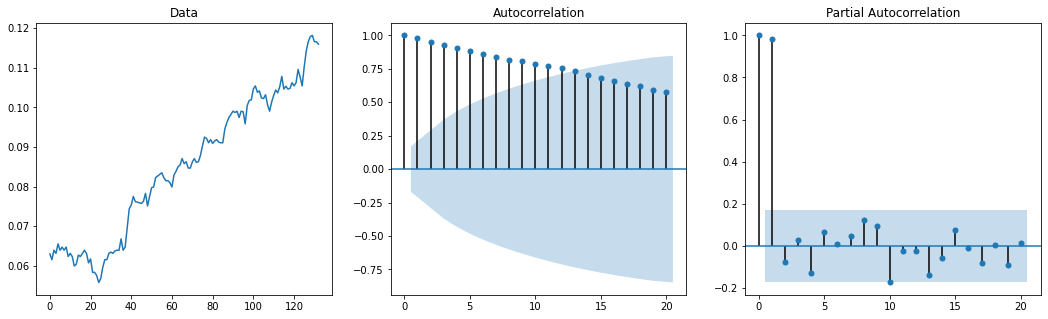

In [ ]:
#LA PLOT
LA = CaliforniaCities.iloc[ :1 , 2 : ]
LA = preprocessing.normalize(LA)
LA = pd.DataFrame(LA)
LA = LA.squeeze()


plot_figs(LA)

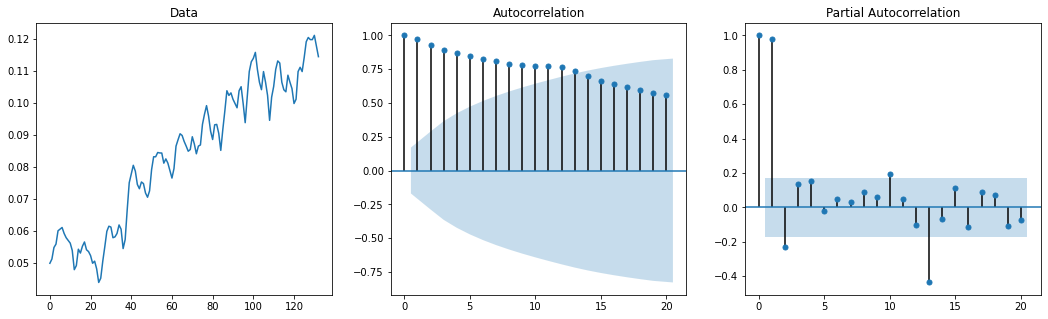

In [ ]:
#SF Plot
plot_figs(SF)

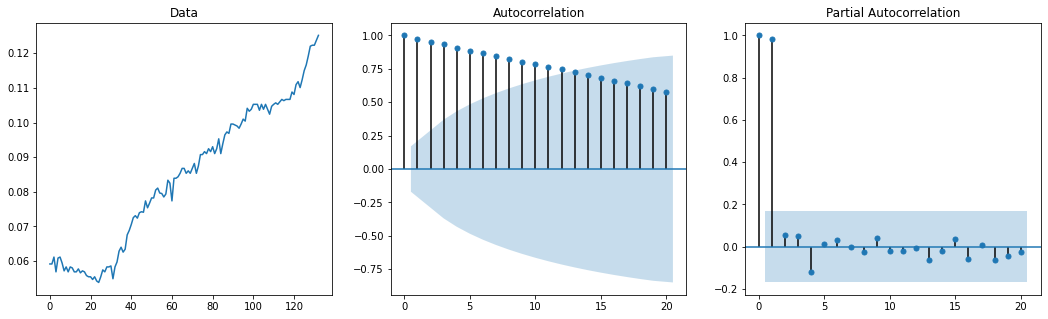

In [ ]:
#Riverside Plot
plot_figs(Riverside)

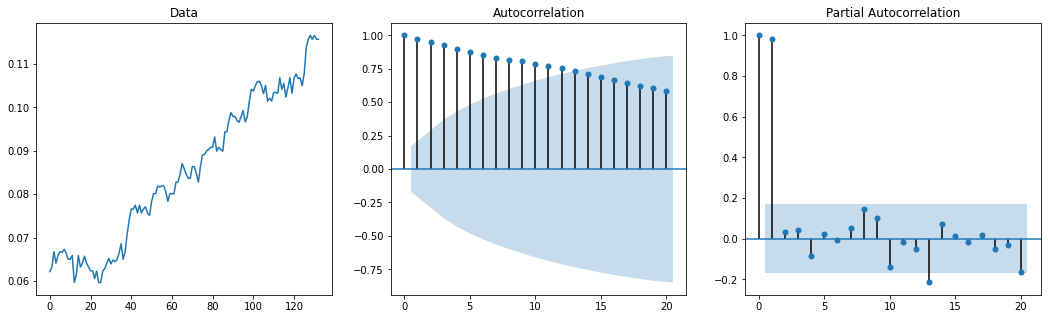

In [ ]:
#SanDiego plots
plot_figs(SanDiego)

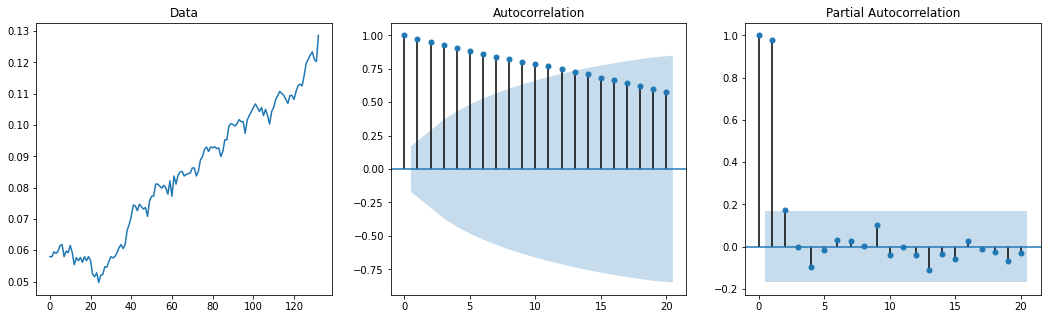

In [ ]:
#Sacramento Plots
plot_figs(Sacramento)

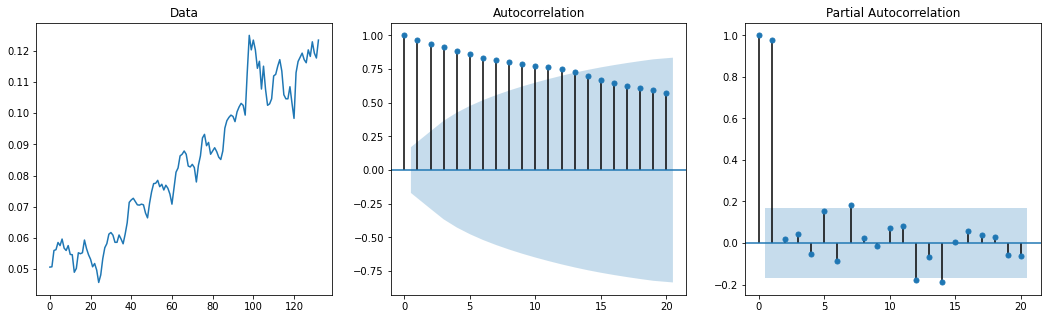

In [ ]:
#San Jose PLots
plot_figs(SanJose)

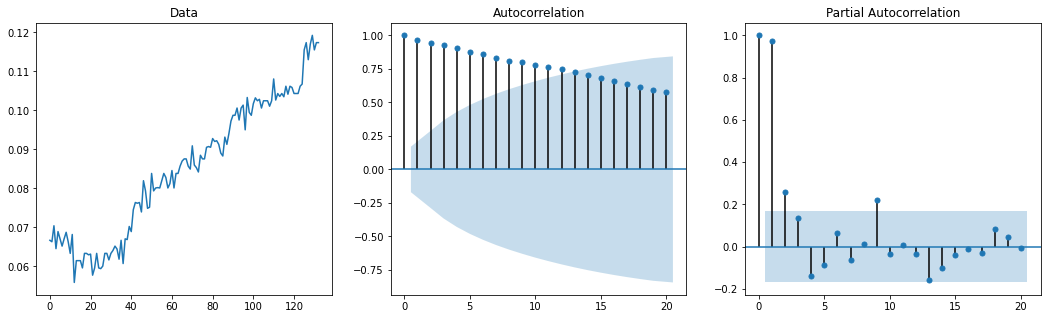

In [ ]:
#Fresno Plot
plot_figs(Fresno)

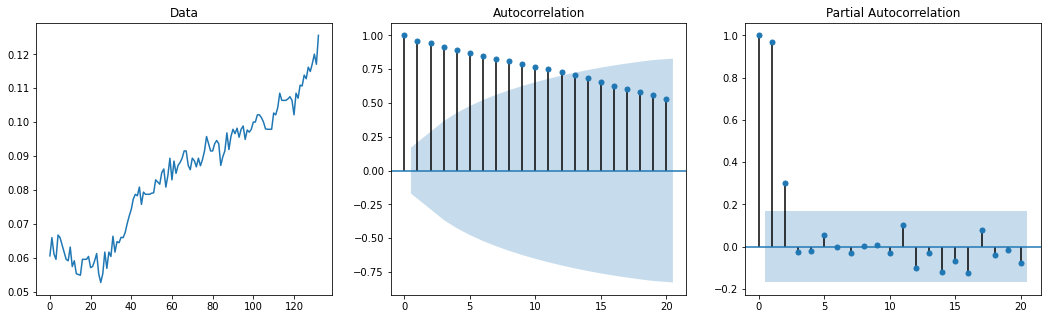

In [ ]:
#Bakersfield plots
plot_figs(Bakersfield)


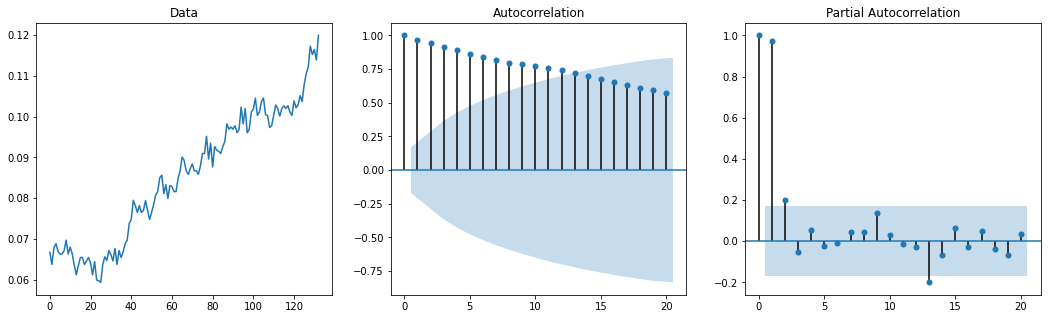

In [ ]:
#Ventura plots
plot_figs(Ventura)

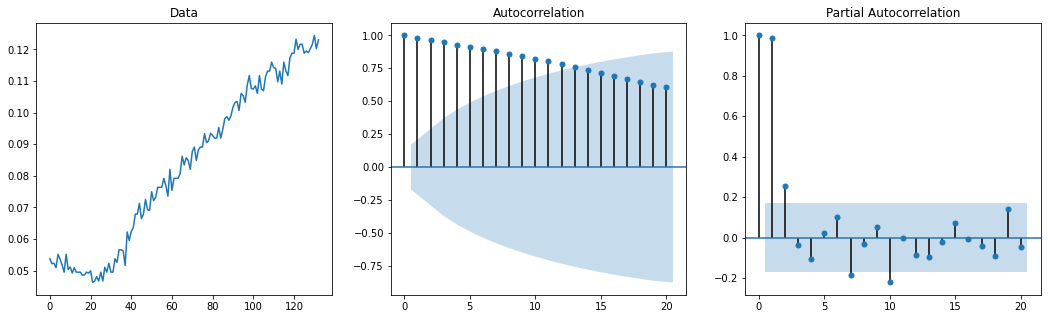

In [ ]:
#Stocktom plots
plot_figs(Stockton)

MSE: 0.0000135501
Correlation: 0.865


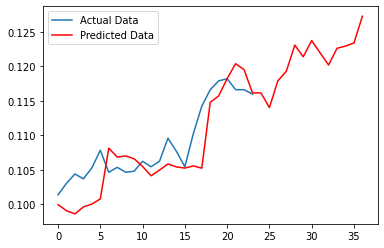

In [ ]:
#LA
n_test = 24 # Number of observations for test
p, d, q = 10, 1, 6 # Parameters of ARIMA model
make_predictions(LA, n_test, p, d, q)

MSE: 0.0000238189
Correlation: 0.870


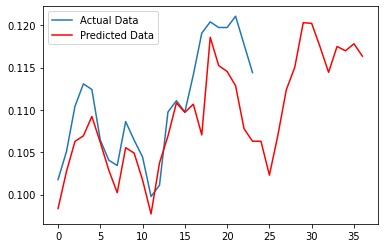

In [ ]:
#SF

n_test = 24 # Number of observations for test
p, d, q = 10, 1, 6 # Parameters of ARIMA model
make_predictions(SF, n_test, p, d, q)

MSE: 0.0000192657
Correlation: 0.952


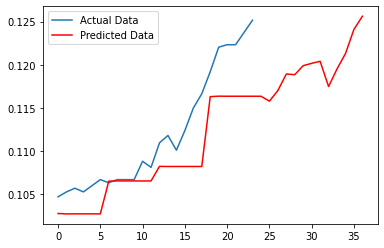

In [ ]:
#Riverside

n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(Riverside, n_test, p, d, q)

MSE: 0.0000066942
Correlation: 0.930


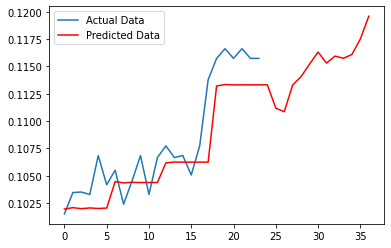

In [ ]:
#SanDiego

n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(SanDiego, n_test, p, d, q)

MSE: 0.0000313752
Correlation: 0.798


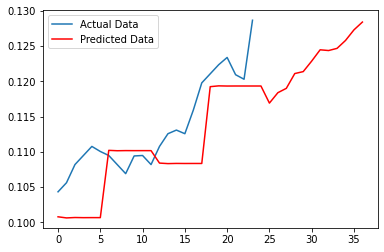

In [ ]:
#Sacramento

n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(Sacramento, n_test, p, d, q)

MSE: 0.0001438250
Correlation: -0.100


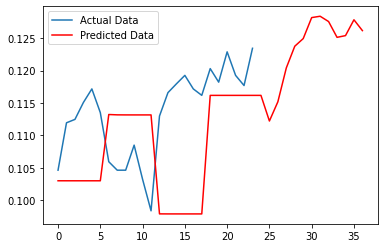

In [ ]:
#SanJose

n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(SanJose, n_test, p, d, q)

MSE: 0.0000157585
Correlation: 0.830


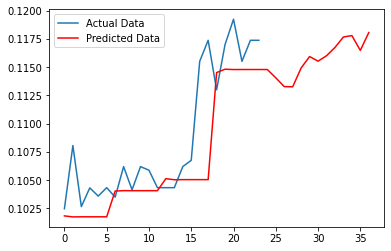

In [ ]:
#Fresno

n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(Fresno, n_test, p, d, q)

MSE: 0.0000354817
Correlation: 0.773


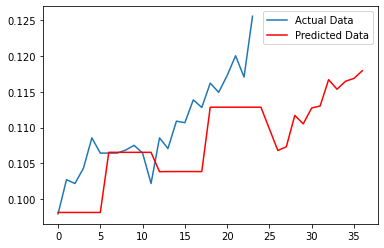

In [ ]:
#Bakersfield

n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(Bakersfield, n_test, p, d, q)

MSE: 0.0000161791
Correlation: 0.916


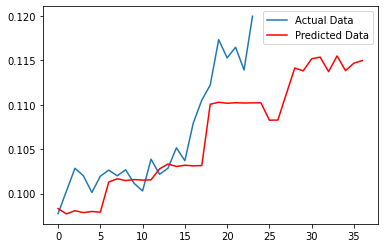

In [ ]:
#Ventura

n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(Ventura, n_test, p, d, q)

MSE: 0.0000144630
Correlation: 0.736


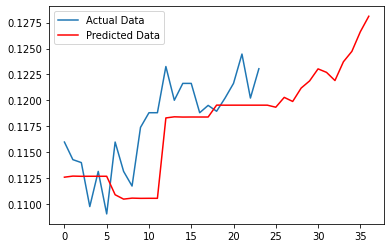

In [ ]:
#Stockton

n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(Stockton, n_test, p, d, q)

###Texas Cities

In [ ]:
# Texas
DALLAS = TexasCities.iloc[:1, 2:]
DALLAS = preprocessing.normalize(DALLAS)
DALLAS = pd.DataFrame(DALLAS)
DALLAS = DALLAS.squeeze()

HOUSTON = TexasCities.iloc[1:2, 2:]
HOUSTON = preprocessing.normalize(HOUSTON)
HOUSTON = pd.DataFrame(HOUSTON)
HOUSTON = HOUSTON.squeeze()

SANANTONIO = TexasCities.iloc[2:3, 2:]
SANANTONIO = preprocessing.normalize(SANANTONIO)
SANANTONIO = pd.DataFrame(SANANTONIO)
SANANTONIO = SANANTONIO.squeeze()

AUSTIN = TexasCities.iloc[3:4, 2:]
AUSTIN = preprocessing.normalize(AUSTIN)
AUSTIN = pd.DataFrame(AUSTIN)
AUSTIN = AUSTIN.squeeze()

ELPASO = TexasCities.iloc[4:5, 2:]
ELPASO = preprocessing.normalize(ELPASO)
ELPASO = pd.DataFrame(ELPASO)
ELPASO = ELPASO.squeeze()

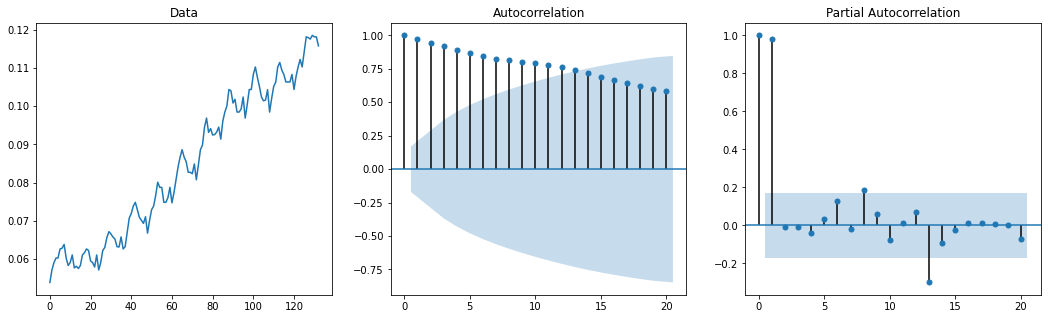

In [ ]:
#DALLAS PLOT
plot_figs(DALLAS)

MSE: 0.0000434485
Correlation: 0.627


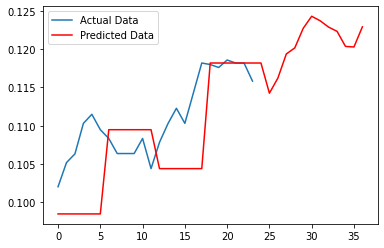

In [ ]:
#DALLAS

n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(DALLAS, n_test, p, d, q)

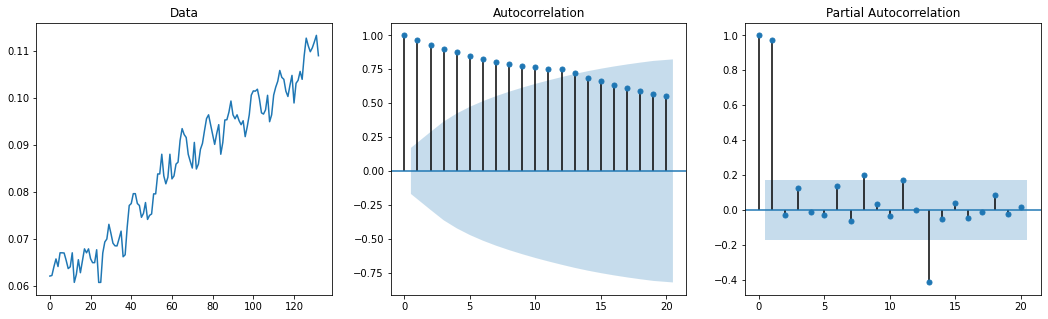

In [ ]:
#HOUSTON
plot_figs(HOUSTON)

MSE: 0.0000316822
Correlation: 0.598


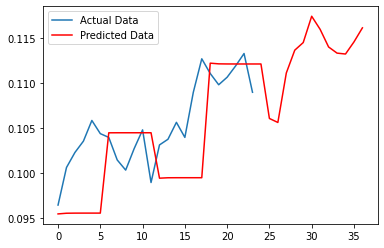

In [ ]:
#HOUSTON
n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(HOUSTON, n_test, p, d, q)

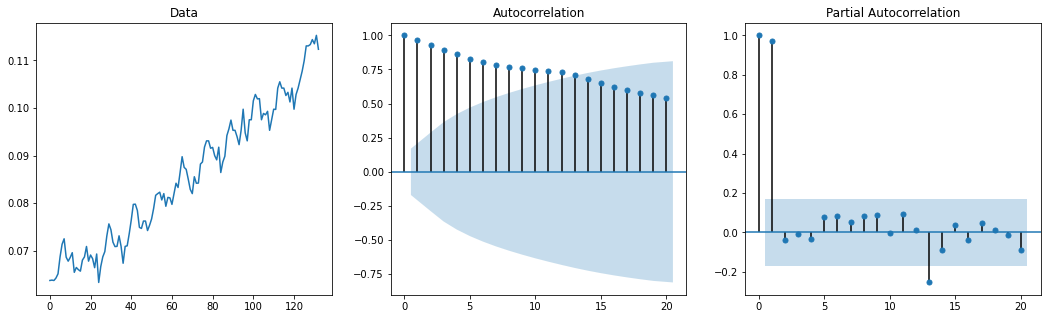

In [ ]:
#SAN ANTONIO
plot_figs(SANANTONIO)

MSE: 0.0000291367
Correlation: 0.728


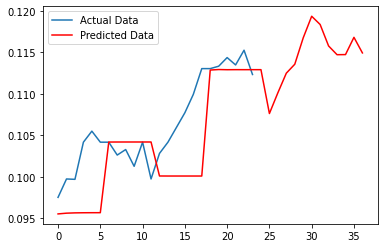

In [ ]:
#SAN ANTONIO
n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(SANANTONIO, n_test, p, d, q)

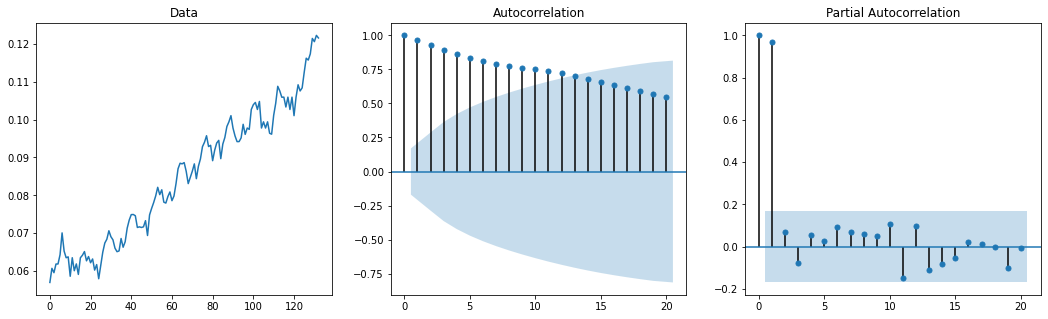

In [ ]:
#AUSTIN
plot_figs(AUSTIN)

MSE: 0.0000480244
Correlation: 0.743


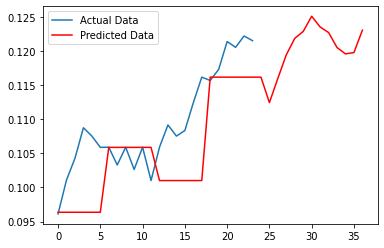

In [ ]:
#AUSTIN
n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(AUSTIN, n_test, p, d, q)

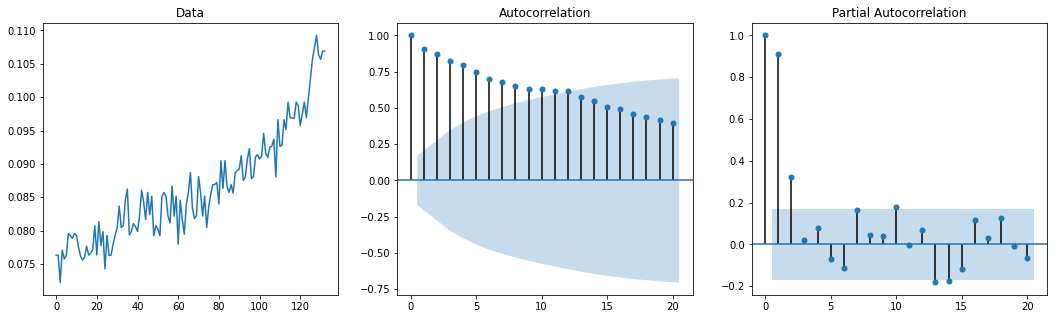

In [ ]:
#ELPASO
plot_figs(ELPASO)

MSE: 0.0000165615
Correlation: 0.844


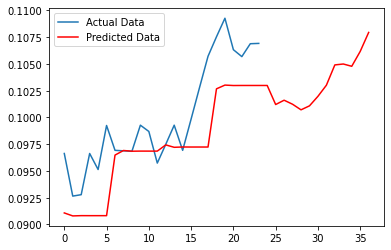

In [ ]:
#ELPASO
n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(ELPASO, n_test, p, d, q)

###Nevada Cities

In [ ]:
#LAS VEGAS
LV = NevadaCities.iloc[:, 2:]
LV = preprocessing.normalize(LV)
LV = pd.DataFrame(LV)
LV = LV.squeeze()

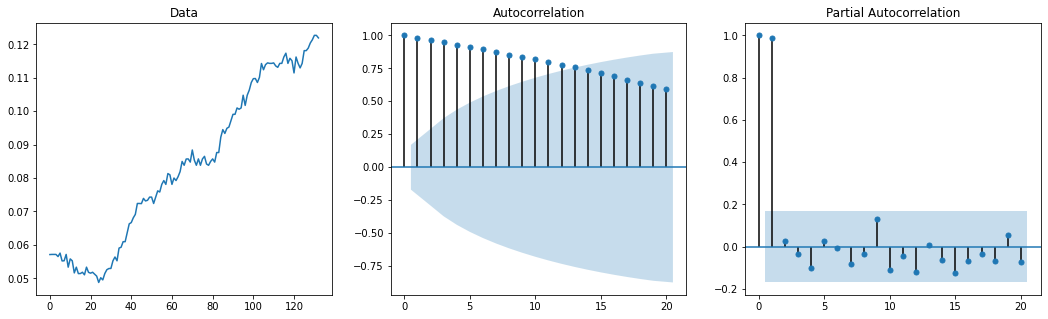

In [ ]:
plot_figs(LV)

MSE: 0.0000076534
Correlation: 0.747


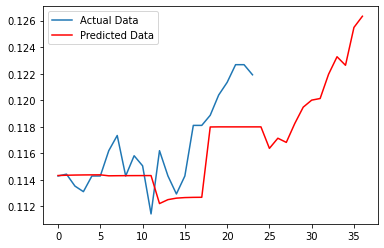

In [ ]:
n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(LV, n_test, p, d, q)

###Arizona Cities

In [ ]:
PHOENIX = ArizonaCities.iloc[:1, 2:]
PHOENIX = preprocessing.normalize(PHOENIX)
PHOENIX = pd.DataFrame(PHOENIX)
PHOENIX = PHOENIX.squeeze()

TUCSON = ArizonaCities.iloc[1:2, 2:]
TUCSON = preprocessing.normalize(TUCSON)
TUCSON = pd.DataFrame(TUCSON)
TUCSON = TUCSON.squeeze()

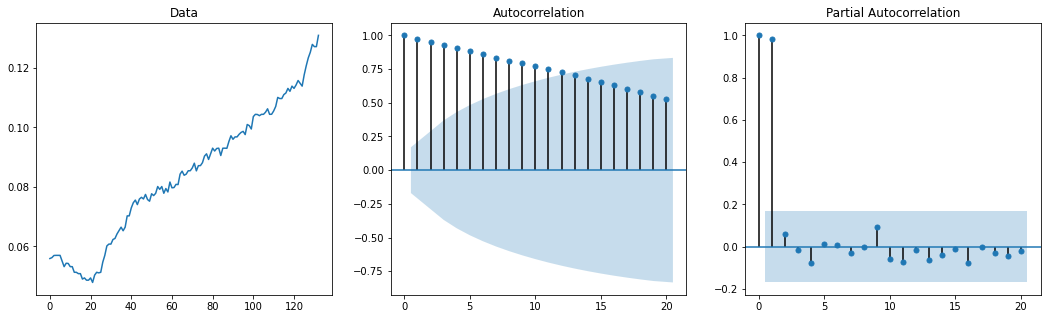

In [ ]:
plot_figs(PHOENIX)

MSE: 0.0000211663
Correlation: 0.953


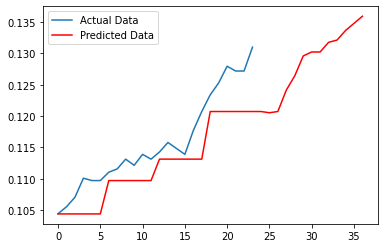

In [ ]:
n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(PHOENIX, n_test, p, d, q)

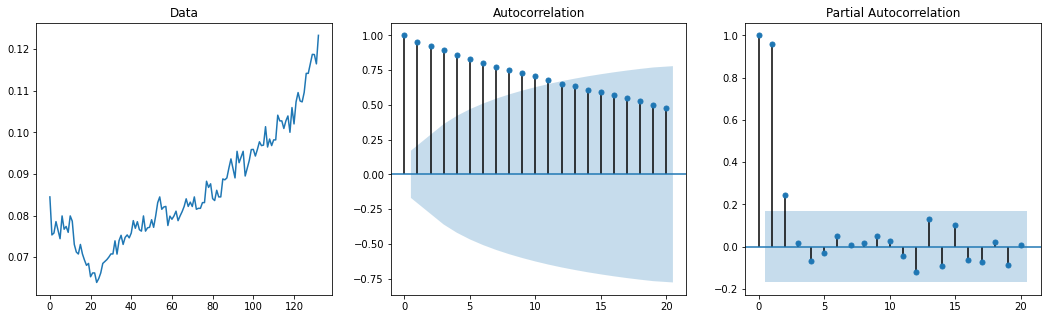

In [ ]:
plot_figs(TUCSON)

MSE: 0.0000258830
Correlation: 0.886


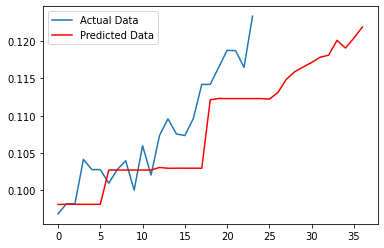

In [ ]:
n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(TUCSON, n_test, p, d, q)

###Washington Cities

In [ ]:
SEATTLE = WashingtonCities.iloc[:, 2:]
SEATTLE = preprocessing.normalize(SEATTLE)
SEATTLE = pd.DataFrame(SEATTLE)
SEATTLE = SEATTLE.squeeze()

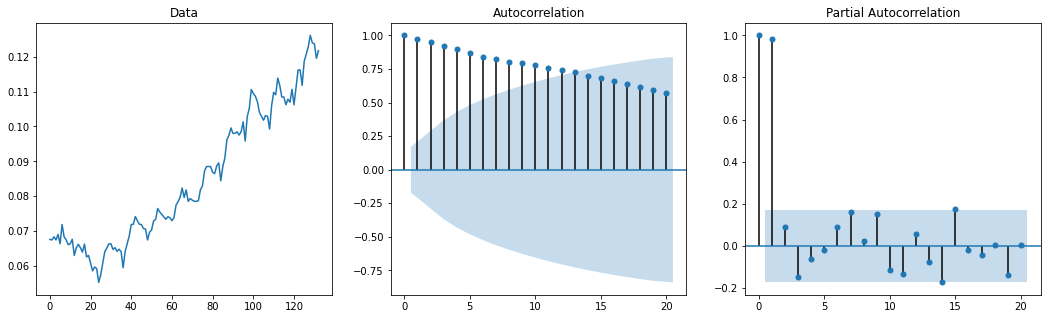

In [ ]:
plot_figs(SEATTLE)

MSE: 0.0000214661
Correlation: 0.899


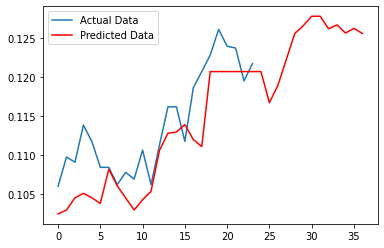

In [ ]:
n_test = 24 # Number of observations for test
p, d, q = 10, 1, 6 # Parameters of ARIMA model
make_predictions(SEATTLE, n_test, p, d, q)

###Oregon Cities

In [ ]:
PORTLAND = OregonCities.iloc[:,2:]
PORTLAND = preprocessing.normalize(PORTLAND)
PORTLAND = pd.DataFrame(PORTLAND)
PORTLAND = PORTLAND.squeeze()

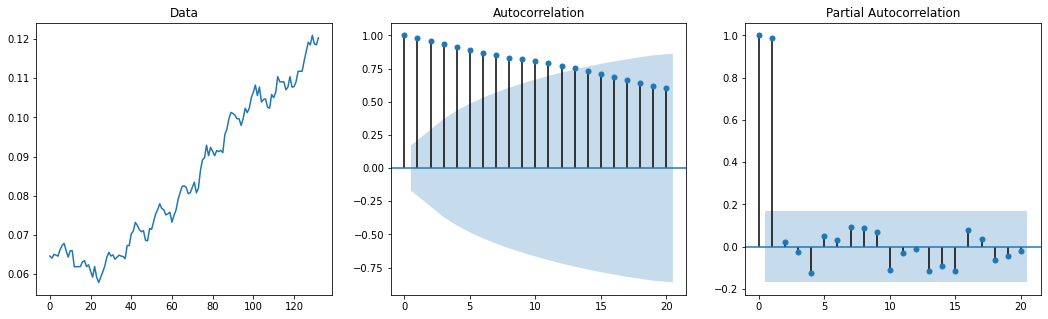

In [ ]:
plot_figs(PORTLAND)

MSE: 0.0000173993
Correlation: 0.832


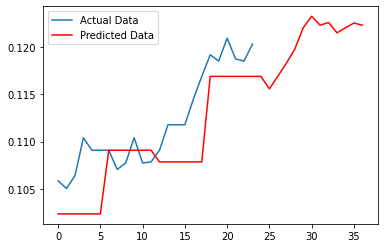

In [ ]:
n_test = 24 # Number of observations for test
p, d, q = 1, 1, 1 # Parameters of ARIMA model
make_predictions(PORTLAND, n_test, p, d, q)

###Clustering DataFrames

In [ ]:
PopulationDataCalifornia = pd.read_csv("california_city_populations.csv")
PopulationDataCalifornia['City'] = PopulationDataCalifornia['City'].str.replace(', California', '')
PopulationDataCalifornia = PopulationDataCalifornia.drop(columns= ['Census', 'Estimates Base'])
PopulationDataCalifornia.head()

,City,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Adelanto city,"31,661","31,864","31,088","31,206","32,522","32,961","33,249","33,952","34,070","34,049"
1,Agoura Hills city,"20,338","20,475","20,544","20,591","20,648","20,740","20,665","20,572","20,411","20,222"
2,Alameda city,"73,946","74,692","75,637","76,479","77,509","78,459","79,091","79,037","78,344","77,624"
3,Albany city,"18,539","18,720","18,957","19,187","19,434","19,662","19,713","20,076","19,885","19,696"
4,Alhambra city,"83,160","83,594","84,120","84,337","84,786","84,843","85,221","84,878","84,373","83,750"


In [ ]:
PopulationDataTexas = pd.read_csv("texas_city_populations.csv")
PopulationDataTexas['City'] = PopulationDataTexas['City'].str.replace(', Texas', '')
PopulationDataTexas = PopulationDataTexas.drop(columns= ['Census', 'Estimates Base'])
PopulationDataTexas.head()

,City,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Abbott city,362,362,361,355,354,354,356,361,365,369
1,Abernathy city,"2,818","2,833","2,822","2,798","2,738","2,724","2,741","2,735","2,711","2,706"
2,Abilene city,"117,805","118,762","119,853","119,797","120,648","121,707","121,883","122,186","122,775","123,420"
3,Ackerly city,220,219,219,225,228,230,229,228,229,232
4,Addison town,"12,565","13,259","14,640","14,871","14,931","15,013","14,945","14,924","15,338","16,263"


In [ ]:
PopulationDataNevada = pd.read_csv("nevada_city_populations.csv")
PopulationDataNevada['City'] = PopulationDataNevada['City'].str.replace(', Nevada', '')
PopulationDataNevada = PopulationDataNevada.drop(columns= ['Census', 'Estimates Base'])
PopulationDataNevada.head()

,City,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Boulder City city,"15,009","15,006","15,124","15,225","15,369","15,553","15,729","15,821","15,960","16,207"
1,Caliente city,"1,159","1,146","1,151","1,129","1,104","1,099","1,088","1,086","1,092","1,076"
2,Carlin city,"2,361","2,362","2,417","2,426","2,374","2,317","2,333","2,316","2,278","2,277"
3,Carson City,"54,981","54,676","54,312","53,726","54,082","54,068","54,147","54,532","55,202","55,916"
4,Elko city,"18,392","18,500","19,232","19,925","20,142","20,105","20,264","20,339","20,383","20,452"


In [ ]:
PopulationDataArizona = pd.read_csv("arizona_city_populations.csv")
PopulationDataArizona['City'] = PopulationDataArizona['City'].str.replace(', Arizona', '')
PopulationDataArizona = PopulationDataArizona.drop(columns= ['Census', 'Estimates Base'])
PopulationDataArizona.head()

,City,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Apache Junction city,"35,918","35,723","36,156","36,732","37,610","38,523","39,661","40,618","41,536","42,571"
1,Avondale city,"76,232","77,279","78,718","79,745","80,726","81,924","83,288","84,742","85,715","87,931"
2,Benson city,"5,126","5,186","5,132","5,040","4,951","4,909","4,863","4,839","4,859","4,880"
3,Bisbee city,"5,611","5,586","5,530","5,381","5,316","5,216","5,221","5,193","5,196","5,225"
4,Buckeye city,"51,350","52,486","54,389","56,603","59,100","61,633","64,641","68,534","74,339","79,620"


In [ ]:
PopulationDataWashington = pd.read_csv("washington_city_populations.csv")
PopulationDataWashington['City'] = PopulationDataWashington['City'].str.replace(', Washington', '')
PopulationDataWashington = PopulationDataWashington.drop(columns= ['Census', 'Estimates Base'])
PopulationDataWashington.head()

,City,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aberdeen city,"16,870","16,696","16,520","16,306","16,201","16,204","16,262","16,409","16,622","16,756"
1,Airway Heights city,"7,563","7,731","7,775","7,832","7,913","8,020","8,065","8,115","9,126","9,485"
2,Albion town,590,595,600,597,595,601,607,615,612,604
3,Algona city,"3,038","3,072","3,114","3,133","3,161","3,182","3,210","3,211","3,218","3,208"
4,Almira town,283,280,276,273,271,271,271,276,277,280


In [ ]:
PopulationDataOregon = pd.read_csv("oregon_city_populations.csv")
PopulationDataOregon['City'] = PopulationDataOregon['City'].str.replace(', Oregon', '')
PopulationDataOregon = PopulationDataOregon.drop(columns= ['Census', 'Estimates Base'])
PopulationDataOregon.head()

,City,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Adair Village city,848,853,852,844,844,845,860,875,880,874
1,Adams city,351,353,355,354,354,351,353,356,357,357
2,Adrian city,177,175,173,172,172,171,171,173,174,173
3,Albany city,"50,327","50,946","51,017","50,937","51,343","51,659","52,716","53,524","54,518","55,338"
4,Amity city,"1,616","1,622","1,619","1,609","1,627","1,627","1,655","1,679","1,702","1,724"


###Extracting Cities we need

In [ ]:
AllCitiesPopulationData = pd.DataFrame()

In [ ]:
AllCitiesPopulationData = PopulationDataCalifornia.loc[PopulationDataCalifornia['City'].isin(['Los Angeles city', 'San Francisco city', 'Riverside city', 'San Diego city', 'Sacramento city', 'San Jose city', 'Fresno city', 'Bakersfield city', 'San Buenaventura (Ventura) city', 'Stockton city'])]


In [ ]:
AllCitiesPopulationData = AllCitiesPopulationData.append(PopulationDataTexas.loc[PopulationDataTexas['City'].isin(['Dallas city', 'Houston city', 'San Antonio city', 'Austin city', 'El Paso city'])], ignore_index= True)


In [ ]:
AllCitiesPopulationData = AllCitiesPopulationData.append(PopulationDataNevada.loc[PopulationDataNevada['City'].isin(['Las Vegas city'])], ignore_index= True)


In [ ]:
AllCitiesPopulationData = AllCitiesPopulationData.append(PopulationDataArizona.loc[PopulationDataArizona['City'].isin(['Phoenix city'])], ignore_index= True)


In [ ]:
AllCitiesPopulationData = AllCitiesPopulationData.append(PopulationDataWashington.loc[PopulationDataWashington['City'].isin(['Seattle city'])], ignore_index= True)


In [ ]:
AllCitiesPopulationData = AllCitiesPopulationData.append(PopulationDataOregon.loc[PopulationDataOregon['City'].isin(['Portland city'])], ignore_index= True)

In [ ]:
AllCitiesPopulationData

,City,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Bakersfield city,"348,987","353,221","357,312","362,834","366,954","371,348","374,699","377,940","381,714","384,145"
1,Fresno city,"497,769","501,429","505,414","508,880","514,100","518,203","521,426","525,373","528,814","531,576"
2,Los Angeles city,"3,795,512","3,820,876","3,851,202","3,881,622","3,909,901","3,938,568","3,963,226","3,975,788","3,977,596","3,979,576"
3,Riverside city,"305,466","309,472","312,323","315,510","317,702","320,483","323,684","326,882","329,654","331,360"
4,Sacramento city,"467,286","470,902","474,226","478,214","482,762","488,133","494,127","500,777","507,737","513,624"
5,San Buenaventura (Ventura) city,"107,435","108,306","109,002","109,339","109,535","109,668","109,893","110,093","110,731","109,106"
6,San Diego city,"1,305,906","1,319,592","1,336,776","1,355,320","1,375,831","1,387,323","1,402,089","1,412,621","1,421,917","1,423,851"
7,San Francisco city,"805,505","815,650","828,876","839,572","850,750","863,010","871,512","878,040","880,696","881,549"
8,San Jose city,"954,940","970,369","983,530","1,001,279","1,014,273","1,025,980","1,030,242","1,032,335","1,028,020","1,021,795"
9,Stockton city,"292,888","295,363","297,045","297,493","301,062","304,550","307,158","310,143","311,628","312,697"


###Clustering the data

In [ ]:
data = AllCitiesPopulationData.drop(columns=['City'])

for key in data.columns:
  data[key] = data[key].str.replace(',', '')
  data[key] = pd.to_numeric(data[key])


Text(0.5, 1.0, 'Population data for all cities')

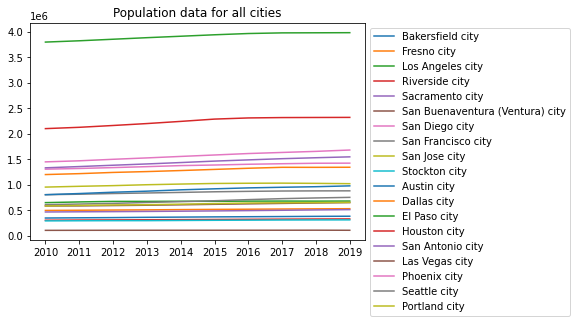

In [ ]:
for i in range(len(data)):
  plt.plot(data.loc[i], label = AllCitiesPopulationData['City'].loc[i])

plt.legend(bbox_to_anchor=(1, 1), loc='bottom left')
plt.title('Population data for all cities')

In [ ]:
#Calculating precent change per year
data.pct_change(axis = 1).head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,NaN,0.012132,0.011582,0.015454,0.011355,0.011974,0.009024,0.008650,0.009986,0.006369
1,NaN,0.007353,0.007947,0.006858,0.010258,0.007981,0.006220,0.007570,0.006550,0.005223
2,NaN,0.006683,0.007937,0.007899,0.007285,0.007332,0.006261,0.003170,0.000455,0.000498
3,NaN,0.013114,0.009212,0.010204,0.006947,0.008753,0.009988,0.009880,0.008480,0.005175
4,NaN,0.007738,0.007059,0.008409,0.009510,0.011126,0.012279,0.013458,0.013898,0.011595


Text(0.5, 1.0, 'California Cities Percent change')

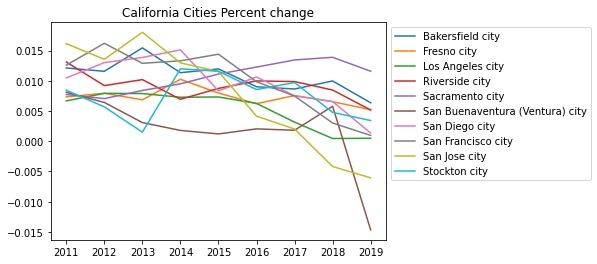

In [ ]:
Calicities = [0,1,2,3,4,5,6,7,8,9]
Texascities = [10,11,12,13]
Nevadacities = [15]
Arizonacities = [16]
Washingtoncities = [17]
Oregoncities = [18]


for i in Calicities:
  plt.plot(data.pct_change(axis = 1).loc[i], label = AllCitiesPopulationData['City'].loc[i])

plt.legend(bbox_to_anchor=(1, 1), loc='bottom left')
plt.title('California Cities Percent change')

Text(0.5, 1.0, 'Texas Cities Percent change')

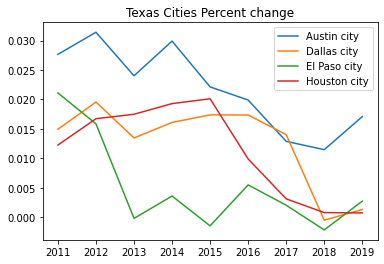

In [ ]:
for i in Texascities:
  plt.plot(data.pct_change(axis = 1).loc[i], label = AllCitiesPopulationData['City'].loc[i])

plt.legend(bbox_to_anchor=(1, 1), loc='bottom left')
plt.title('Texas Cities Percent change')

Text(0.5, 1.0, 'Nevada Cities Percent change')

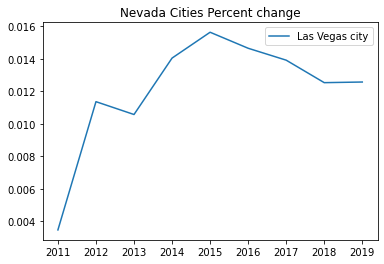

In [ ]:
for i in Nevadacities:
  plt.plot(data.pct_change(axis = 1).loc[i], label = AllCitiesPopulationData['City'].loc[i])

plt.legend(bbox_to_anchor=(1, 1), loc='bottom left')
plt.title('Nevada Cities Percent change')

Text(0.5, 1.0, 'Arizona Cities Percent change')

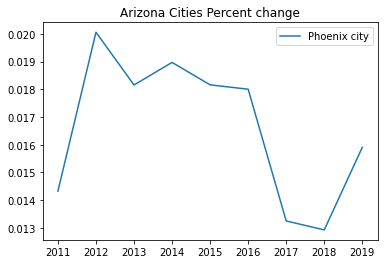

In [ ]:
for i in Arizonacities:
  plt.plot(data.pct_change(axis = 1).loc[i], label = AllCitiesPopulationData['City'].loc[i])

plt.legend(bbox_to_anchor=(1, 1), loc='bottom left')
plt.title('Arizona Cities Percent change')

Text(0.5, 1.0, 'Washington Cities Percent change')

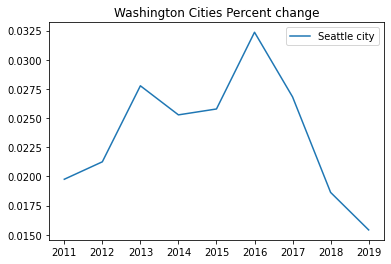

In [ ]:
for i in Washingtoncities:
  plt.plot(data.pct_change(axis = 1).loc[i], label = AllCitiesPopulationData['City'].loc[i])

plt.legend(bbox_to_anchor=(1, 1), loc='bottom left')
plt.title('Washington Cities Percent change')

Text(0.5, 1.0, 'Oregon Cities Percent change')

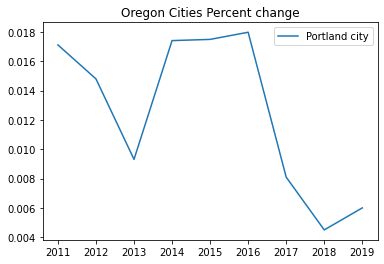

In [ ]:
for i in Oregoncities:
  plt.plot(data.pct_change(axis = 1).loc[i], label = AllCitiesPopulationData['City'].loc[i])

plt.legend(bbox_to_anchor=(1, 1), loc='bottom left')
plt.title('Oregon Cities Percent change')

In [ ]:
seed = 0
np.random.seed(seed)

In [ ]:
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3, metric="dtw",max_iter=10,random_state=seed)
y_pred = dba_km.fit_predict(data)
print(y_pred)

DBA k-means
[0 0 2 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0]


In [ ]:
cluster1 = []
cluster2 = []
for i in range(len(y_pred)):
  if 0 == y_pred[i]:
    cluster1 += [AllCitiesPopulationData['City'].iloc[i]]
  elif 1 == y_pred[i]:
    cluster2 += [AllCitiesPopulationData['City'].iloc[i]]
print(cluster1)
print(cluster2)
print(AllCitiesPopulationData['City'].iloc[2])

['Bakersfield city', 'Fresno city', 'Riverside city', 'Sacramento city', 'San Buenaventura (Ventura) city', 'San Francisco city', 'San Jose city', 'Stockton city', 'Austin city', 'El Paso city', 'Las Vegas city', 'Seattle city', 'Portland city']
['San Diego city', 'Dallas city', 'Houston city', 'San Antonio city', 'Phoenix city']
Los Angeles city


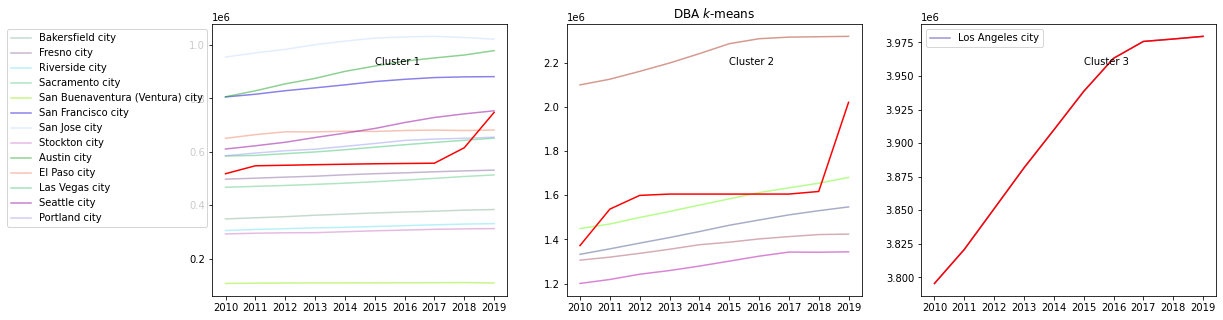

In [ ]:
plt.figure(figsize=(18,5))
for yi in range(3):
    plt.subplot(1, 3, 1 + yi)
    for i, xx in data.loc[y_pred == yi].iterrows():
      plt.plot(xx, "k-", alpha=.5, label = AllCitiesPopulationData['City'].iloc[i], c = np.random.rand(3,))
    plt.plot(dba_km.cluster_centers_[yi], "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    elif yi == 0:
        plt.legend(bbox_to_anchor=(0, 1), loc='upper right')
    else: 
      plt.legend()